<a href="https://colab.research.google.com/github/fmathews11/Football_Field_Goals/blob/main/Predicting_Field_Goals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, re
from pandas.api.types import is_string_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
pd.set_option('display.max_columns', None)
from google.colab import output
output.clear()
df = pd.read_csv('https://raw.githubusercontent.com/fmathews11/Football_Field_Goals/main/historical_field_goal_data.csv')
#print(*((idx,i) for idx,i in enumerate(df.columns)),sep = '\n')
df = df.drop([df.columns[i] for i in [0,11,12,31,33,27]],axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9286 entries, 0 to 9285
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   week                 9286 non-null   int64  
 1   away                 9286 non-null   object 
 2   home                 9286 non-null   object 
 3   stadium              9286 non-null   object 
 4   temperature          7034 non-null   float64
 5   humidity             6787 non-null   float64
 6   wind_speed           6899 non-null   float64
 7   wind_direction       6881 non-null   object 
 8   condition            9250 non-null   object 
 9   surface              9286 non-null   object 
 10  away_score           9286 non-null   int64  
 11  home_score           9286 non-null   int64  
 12  off                  9286 non-null   object 
 13  def                  9286 non-null   object 
 14  quarter              9286 non-null   int64  
 15  minutes              9286 non-null   i

In [2]:
columns_to_encode = [i for i in pd.Series({col:df[col].nunique() for col in df if is_string_dtype(df[col])}).index]
le_dict = {key:LabelEncoder() for key in columns_to_encode}
for col in le_dict.keys():
  print(f"Label Encoding {col}")
  df[col] = le_dict[col].fit_transform(df[col])
df

Label Encoding away
Label Encoding home
Label Encoding stadium
Label Encoding wind_direction
Label Encoding condition
Label Encoding surface
Label Encoding off
Label Encoding def


,week,away,home,stadium,temperature,humidity,wind_speed,wind_direction,condition,surface,away_score,home_score,off,def,quarter,minutes,seconds,offense_score,defense_score,timeouts_offense,timeouts_defense,down,yards_to_go,yards_from_own_goal,penalty,fumble,block,kicker_id,distance,made
0,1,8,23,32,77.0,63.0,5.0,16,8,4,24,17,23,8,2,9,14,0,0,3,3,4,4,96,0,0,0,2886,22,1
1,1,8,23,32,77.0,63.0,5.0,16,8,4,24,17,8,23,3,0,45,14,10,2,3,4,15,85,0,0,0,4452,33,1
2,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,5,13,2,5,36,14,7,1,3,4,4,83,0,0,0,2820,35,1
3,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,13,5,2,0,6,14,24,1,1,2,10,81,0,0,0,2888,37,0
4,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,5,13,3,10,7,31,14,3,3,4,6,92,0,0,0,2820,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9281,20,3,15,2,40.0,70.0,7.0,6,4,5,24,38,3,15,4,3,19,21,38,3,3,4,28,67,0,0,0,54578,51,1
9282,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,1,5,14,0,0,3,3,4,11,69,0,0,0,53628,49,1
9283,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,2,1,4,3,14,3,2,4,6,86,0,0,0,53628,34,1
9284,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,3,11,31,6,21,3,3,4,7,66,0,0,0,53628,52,1


In [3]:
df.isna().sum()[lambda x: x >1]

temperature    2252
humidity       2499
wind_speed     2387
dtype: int64

In [4]:
#Filtering by stadiums with a minimum of 50 kicks recorded
df = df[df.stadium.isin(df.groupby('stadium').size().sort_values()[lambda x: x > 50].index.tolist())]

#Imputing the wind direction with the most common value by stadium
df['wind_direction_mode'] = df.groupby('stadium').wind_direction.transform(lambda x: x.value_counts().index[0])

df.wind_direction = df.wind_direction.fillna(df.wind_direction_mode)
df.drop('wind_direction_mode',axis = 1,inplace= True)
df

,week,away,home,stadium,temperature,humidity,wind_speed,wind_direction,condition,surface,away_score,home_score,off,def,quarter,minutes,seconds,offense_score,defense_score,timeouts_offense,timeouts_defense,down,yards_to_go,yards_from_own_goal,penalty,fumble,block,kicker_id,distance,made
0,1,8,23,32,77.0,63.0,5.0,16,8,4,24,17,23,8,2,9,14,0,0,3,3,4,4,96,0,0,0,2886,22,1
1,1,8,23,32,77.0,63.0,5.0,16,8,4,24,17,8,23,3,0,45,14,10,2,3,4,15,85,0,0,0,4452,33,1
2,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,5,13,2,5,36,14,7,1,3,4,4,83,0,0,0,2820,35,1
3,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,13,5,2,0,6,14,24,1,1,2,10,81,0,0,0,2888,37,0
4,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,5,13,3,10,7,31,14,3,3,4,6,92,0,0,0,2820,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9281,20,3,15,2,40.0,70.0,7.0,6,4,5,24,38,3,15,4,3,19,21,38,3,3,4,28,67,0,0,0,54578,51,1
9282,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,1,5,14,0,0,3,3,4,11,69,0,0,0,53628,49,1
9283,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,2,1,4,3,14,3,2,4,6,86,0,0,0,53628,34,1
9284,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,3,11,31,6,21,3,3,4,7,66,0,0,0,53628,52,1


In [5]:
def assign_month(x):
  if x.week in [1,2,3]: return 9
  elif x.week in [4,5,6,7,8]: return 10
  elif x.week in [9,10,11,12]: return 11
  elif x.week in [13,14,15,16]: return 12
  elif x.week in [17,18,19,20]:return 1
  else: return 2
df['month'] = df.apply(lambda x: assign_month(x),axis = 1)
df

,week,away,home,stadium,temperature,humidity,wind_speed,wind_direction,condition,surface,away_score,home_score,off,def,quarter,minutes,seconds,offense_score,defense_score,timeouts_offense,timeouts_defense,down,yards_to_go,yards_from_own_goal,penalty,fumble,block,kicker_id,distance,made,month
0,1,8,23,32,77.0,63.0,5.0,16,8,4,24,17,23,8,2,9,14,0,0,3,3,4,4,96,0,0,0,2886,22,1,9
1,1,8,23,32,77.0,63.0,5.0,16,8,4,24,17,8,23,3,0,45,14,10,2,3,4,15,85,0,0,0,4452,33,1,9
2,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,5,13,2,5,36,14,7,1,3,4,4,83,0,0,0,2820,35,1,9
3,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,13,5,2,0,6,14,24,1,1,2,10,81,0,0,0,2888,37,0,9
4,1,13,5,45,67.0,66.0,13.0,5,18,5,21,41,5,13,3,10,7,31,14,3,3,4,6,92,0,0,0,2820,26,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9281,20,3,15,2,40.0,70.0,7.0,6,4,5,24,38,3,15,4,3,19,21,38,3,3,4,28,67,0,0,0,54578,51,1,1
9282,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,1,5,14,0,0,3,3,4,11,69,0,0,0,53628,49,1,2
9283,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,2,1,4,3,14,3,2,4,6,86,0,0,0,53628,34,1,2
9284,21,15,32,41,63.0,78.0,9.0,9,1,5,9,31,15,32,3,11,31,6,21,3,3,4,7,66,0,0,0,53628,52,1,2


In [6]:
imp = IterativeImputer(initial_strategy='most_frequent')
df_imputed = pd.DataFrame(imp.fit_transform(df),columns = df.columns)
df_imputed

,week,away,home,stadium,temperature,humidity,wind_speed,wind_direction,condition,surface,away_score,home_score,off,def,quarter,minutes,seconds,offense_score,defense_score,timeouts_offense,timeouts_defense,down,yards_to_go,yards_from_own_goal,penalty,fumble,block,kicker_id,distance,made,month
0,1.0,8.0,23.0,32.0,77.0,63.0,5.0,16.0,8.0,4.0,24.0,17.0,23.0,8.0,2.0,9.0,14.0,0.0,0.0,3.0,3.0,4.0,4.0,96.0,0.0,0.0,0.0,2886.0,22.0,1.0,9.0
1,1.0,8.0,23.0,32.0,77.0,63.0,5.0,16.0,8.0,4.0,24.0,17.0,8.0,23.0,3.0,0.0,45.0,14.0,10.0,2.0,3.0,4.0,15.0,85.0,0.0,0.0,0.0,4452.0,33.0,1.0,9.0
2,1.0,13.0,5.0,45.0,67.0,66.0,13.0,5.0,18.0,5.0,21.0,41.0,5.0,13.0,2.0,5.0,36.0,14.0,7.0,1.0,3.0,4.0,4.0,83.0,0.0,0.0,0.0,2820.0,35.0,1.0,9.0
3,1.0,13.0,5.0,45.0,67.0,66.0,13.0,5.0,18.0,5.0,21.0,41.0,13.0,5.0,2.0,0.0,6.0,14.0,24.0,1.0,1.0,2.0,10.0,81.0,0.0,0.0,0.0,2888.0,37.0,0.0,9.0
4,1.0,13.0,5.0,45.0,67.0,66.0,13.0,5.0,18.0,5.0,21.0,41.0,5.0,13.0,3.0,10.0,7.0,31.0,14.0,3.0,3.0,4.0,6.0,92.0,0.0,0.0,0.0,2820.0,26.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,20.0,3.0,15.0,2.0,40.0,70.0,7.0,6.0,4.0,5.0,24.0,38.0,3.0,15.0,4.0,3.0,19.0,21.0,38.0,3.0,3.0,4.0,28.0,67.0,0.0,0.0,0.0,54578.0,51.0,1.0,1.0
9008,21.0,15.0,32.0,41.0,63.0,78.0,9.0,9.0,1.0,5.0,9.0,31.0,15.0,32.0,1.0,5.0,14.0,0.0,0.0,3.0,3.0,4.0,11.0,69.0,0.0,0.0,0.0,53628.0,49.0,1.0,2.0
9009,21.0,15.0,32.0,41.0,63.0,78.0,9.0,9.0,1.0,5.0,9.0,31.0,15.0,32.0,2.0,1.0,4.0,3.0,14.0,3.0,2.0,4.0,6.0,86.0,0.0,0.0,0.0,53628.0,34.0,1.0,2.0
9010,21.0,15.0,32.0,41.0,63.0,78.0,9.0,9.0,1.0,5.0,9.0,31.0,15.0,32.0,3.0,11.0,31.0,6.0,21.0,3.0,3.0,4.0,7.0,66.0,0.0,0.0,0.0,53628.0,52.0,1.0,2.0


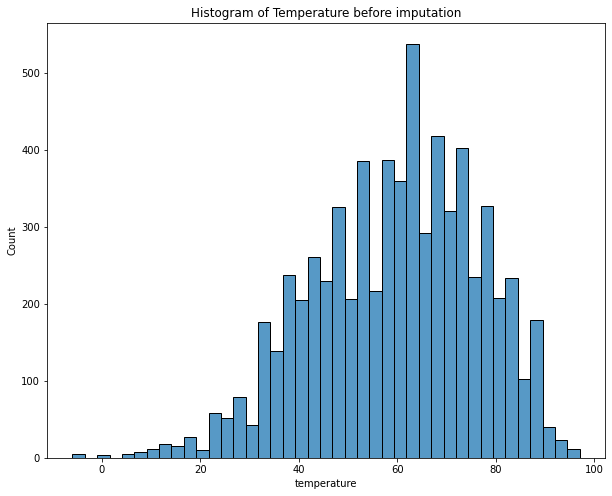

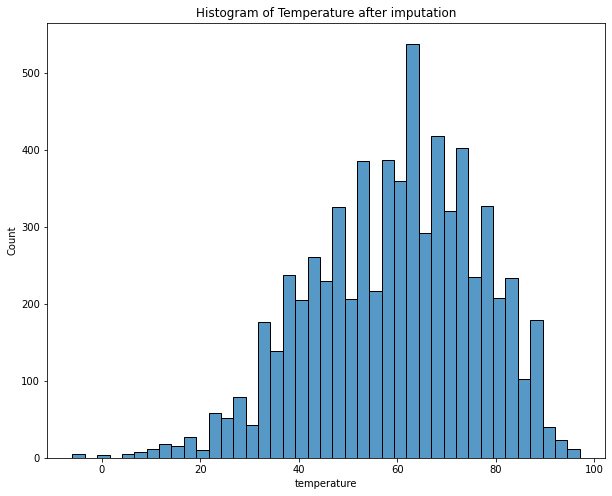

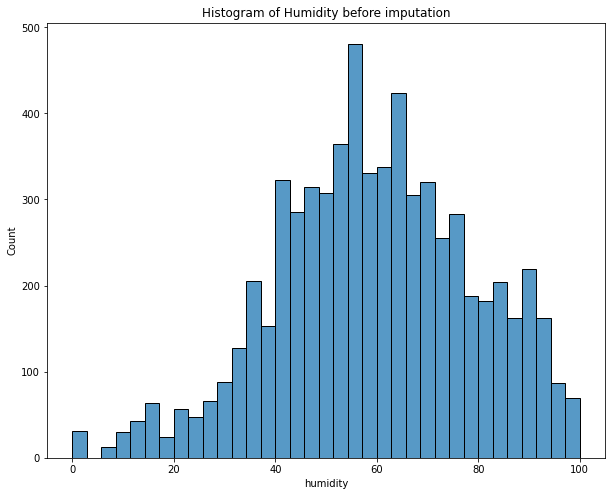

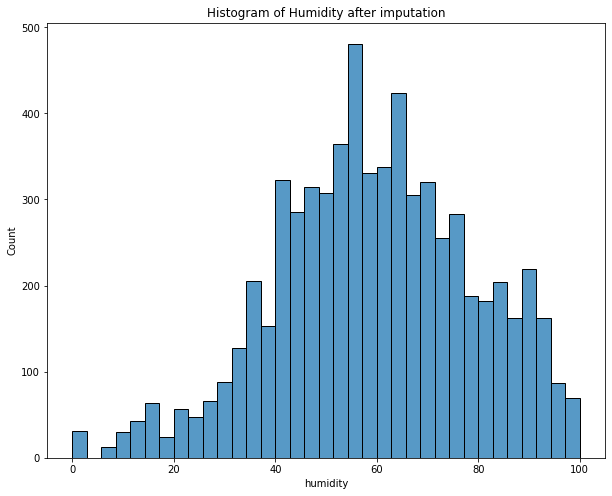

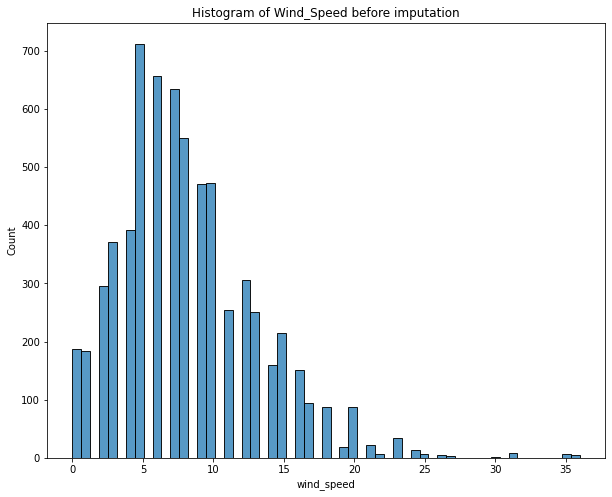

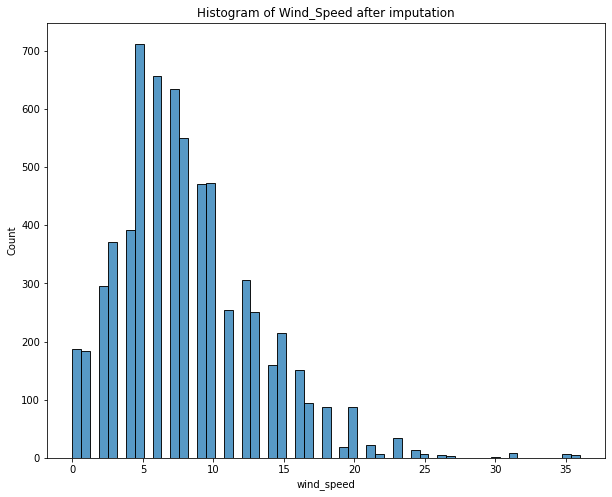

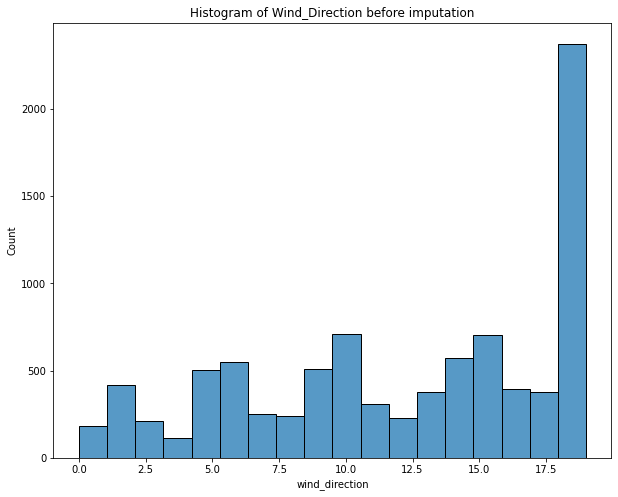

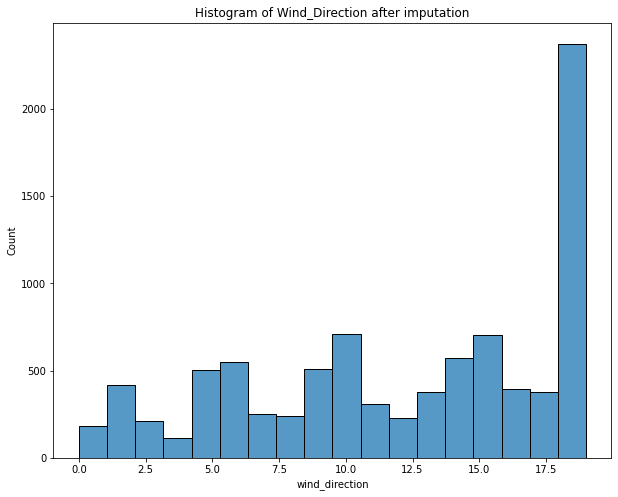

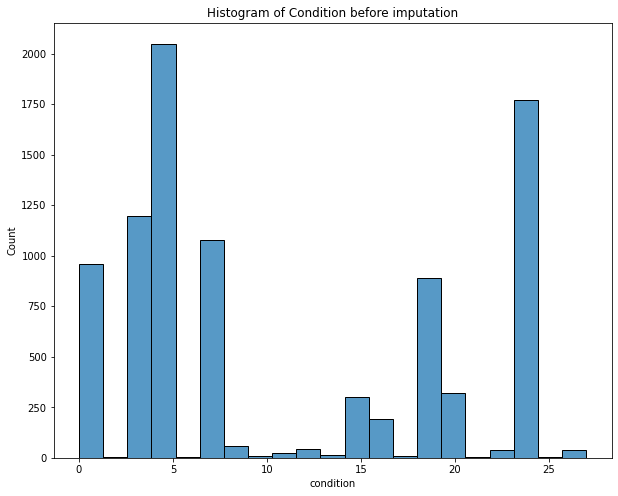

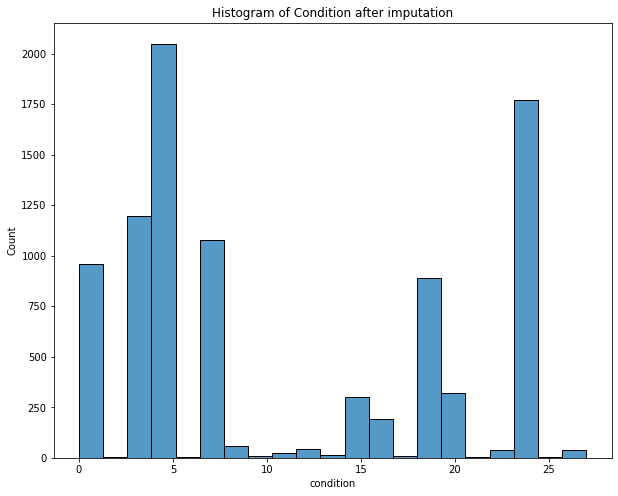

In [7]:
for col in ['temperature', 'humidity', 'wind_speed', 'wind_direction', 'condition']:
  plt.figure(figsize = (10,8))
  sns.histplot(data = df,
               x = col)
  plt.title(f"Histogram of {col.title()} before imputation")
  plt.show();
  plt.figure(figsize = (10,8))
  sns.histplot(data = df,
               x = col)
  plt.title(f"Histogram of {col.title()} after imputation")
  plt.show();

In [8]:
def train_and_evaluate_model(X,y,model):

  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 23,stratify = y)
  print(str(model)[:-2])
  model.fit(X_train,y_train)
  print("Training Accuracy")
  print(cross_val_score(model,X_train,y_train))
  print("Testing Accuracy")
  print(cross_val_score(model,X_test,y_test))
  print("Training ROC")
  print(cross_val_score(model,X_train,y_train,scoring = 'roc_auc'))
  print("Testing ROC")
  print(cross_val_score(model,X_test,y_test,scoring = 'roc_auc'))
  return model

In [21]:
clf = train_and_evaluate_model(df_imputed.drop(["made","week","fumble","block"],axis =1),df_imputed.made,XGBClassifier())

XGBClassifier
Training Accuracy
[0.84535368 0.84049931 0.84188627 0.84466019 0.84732824]
Testing Accuracy
[0.8365651  0.8365651  0.82548476 0.83611111 0.83888889]
Training ROC
[0.77770945 0.75549459 0.76271396 0.75249258 0.75560836]
Testing ROC
[0.76869806 0.76194598 0.69107802 0.76080827 0.75293703]


In [22]:
feat_dict = dict(zip(clf.get_booster().feature_names,clf.feature_importances_))
sorted(feat_dict.items(),key = lambda val: val[1],reverse = True)

[('distance', 0.17378274),
 ('yards_from_own_goal', 0.1630493),
 ('down', 0.043821517),
 ('away_score', 0.03812074),
 ('home', 0.033496752),
 ('timeouts_offense', 0.03318813),
 ('offense_score', 0.033050377),
 ('home_score', 0.031950623),
 ('seconds', 0.031052075),
 ('temperature', 0.030646602),
 ('def', 0.028723778),
 ('humidity', 0.028584516),
 ('timeouts_defense', 0.028411418),
 ('wind_speed', 0.028263513),
 ('yards_to_go', 0.028194338),
 ('stadium', 0.027094755),
 ('month', 0.026156232),
 ('off', 0.025967471),
 ('kicker_id', 0.025097214),
 ('away', 0.02360256),
 ('condition', 0.022688132),
 ('minutes', 0.020748258),
 ('defense_score', 0.020522343),
 ('wind_direction', 0.019025115),
 ('quarter', 0.018817566),
 ('surface', 0.015943972),
 ('penalty', 0.0)]